# 📈 Part 1: EDA
**Data used**:
Dataset contains the top 50,000 Stack Overflow questions retrieved using the StackExchange Data Explorer. 

The data was filtered to include:
- Questions (PostTypeId = 1) with at least 5 tags
- Published between January 1, 2023 and April 30, 2025
- With at least 1 answer
- Having a Score > 0 and ViewCount ≥ 1000
- Ordered by ViewCount (most viewed first)

The extracted columns include:
- Id, Title, Body, Tags, Score, ViewCount, FavoriteCount, AnswerCount, and CreationDate.

This selection ensures we analyze high-quality and relevant questions with substantial engagement.
_________

# 0️⃣ Step 0: Preparation
_________

## Import & Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from bs4 import BeautifulSoup

import nltk
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TreebankWordTokenizer

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Should be installed if not yet
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger_eng')
#nltk.download('wordnet')
#nltk.download('stopwords')

In [3]:
df = pd.read_csv('../data/stackoverflow_questions.csv')

## Set style

In [4]:
sns.set_style('darkgrid')
default_color = '#825ea2' 
pd.set_option('display.max_columns', None)

import warnings
from bs4 import XMLParsedAsHTMLWarning
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

## Functions

In [5]:
# POS mapper
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Cleaning and defining exeptions
def clean_text(text):
    # tools
    tokenizer = TreebankWordTokenizer()
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    lemmatization_exceptions = {'pandas','keras'}

    text = text.strip()  
    text = text.replace('c++', 'cplusplus').replace('c#', 'csharp').replace('next.js', 'nextjs').replace('node.js', 'nodejs')
    
    text = BeautifulSoup(text, 'html.parser').get_text()
    text = text.lower()

    
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip() 

    text = text.replace('cplusplus', 'c++').replace('csharp', 'c#').replace('nextjs', 'next.js').replace('nodejs', 'node.js')

    # tokenization
    tokens = tokenizer.tokenize(text)

    # lemmatization
    tagged = pos_tag(tokens)
    tokens = [
        word if word in lemmatization_exceptions
        else lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in tagged
    ]

    # delete stop words
    tokens = [w for w in tokens if w not in stop_words]


    return ' '.join(tokens)

def remove_custom_stopwords(text, custom_stopwords):
    tokens = text.split()
    filtered = [w for w in tokens if w not in custom_stopwords]
    return ' '.join(filtered)


# Comparison of top tags by year
def compare_top_tags_by_year(df):
    print("\n=== COMPARISON OF POPULAR TAGS BY YEAR ===")
    
    years_to_compare = [2022, 2023, 2024, 2025]
    
    for year in years_to_compare:
        year_tags = df[df['Year'] == year]['Tags'].value_counts()
        total_questions = len(df[df['Year'] == year]) // 5
        
        print(f"\n{year} year (questions: {total_questions:,}, tags: {len(year_tags)}):")
        print("Top 10 tags:")
        for i, (tag, count) in enumerate(year_tags.head(10).items(), 1):
            percentage = (count / total_questions) * 100
            print(f"  {i:2d}. {tag:<20} {count:4d} ({percentage:4.1f}%)")
            
def analyze_tag_trends(df):
    print("\n=== TREND TAG ANALYSIS ===")
    
    tags_2023 = set(df[df['Year'] == 2023]['Tags'].unique())
    tags_2024 = set(df[df['Year'] == 2024]['Tags'].unique())
    tags_2025 = set(df[df['Year'] == 2025]['Tags'].unique())
    
    
    disappeared_tags_2024 = tags_2023 - tags_2024
    new_tags_2024 = tags_2024 - tags_2023
    
    disappeared_tags = tags_2024 - tags_2025
    new_tags_2025 = tags_2025 - tags_2024
    
    stable_tags = tags_2023 & tags_2024 & tags_2025 
    
    print(f"Tags in 2023: {len(tags_2023)}")
    print(f"Tags in 2024: {len(tags_2024)}")
    print(f"Tags in 2025: {len(tags_2025)}")
    print(f"Stable tags (in all years): {len(stable_tags)}")
    
    print(f"\nDisappeared in 2024: {len(disappeared_tags_2024)}")
    print(f"Appeared in 2024: {len(new_tags_2024)}")
    print(f"Disappeared in 2025: {len(disappeared_tags)}")
    print(f"Appeared in 2025: {len(new_tags_2025)}\n")
    
    print(f"Dictionary changed in 2024 by: {((len(tags_2024) - len(tags_2023))/len(tags_2023)*100):+.1f}%")
    print(f"Dictionary changed in 2025 by: {((len(tags_2025) - len(tags_2024))/len(tags_2024)*100):+.1f}%")
    

    print(f"\nExamples of disappeared tags in 2024: {list(disappeared_tags_2024)[:10]}")
    print(f"\nExamples of disappeared tags in 2025: {list(disappeared_tags)[:10]}")
    
    print(f"\nExamples of new tags in 2025: {list(new_tags_2025)[:10]}")
    
    print(f"\nExamples of stable tags: {list(stable_tags)[:10]}")



def describe_iqr_threshold(series, name='Variable'):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr

    print(f'{name} - Q1 (25%): {q1:.2f}')
    print(f'{name} - Q3 (75%): {q3:.2f}')
    print(f'{name} - IQR (Q3 - Q1): {iqr:.2f}')
    print(f'{name} - Recommended upper threshold (Q3 + 1.5 * IQR): {upper_bound:.0f}')
    
    return upper_bound

# 1️⃣ Step 1: General Overview  

In [6]:
df.head(3)

,Id,Title,Body,Tags,Score,ViewCount,FavoriteCount,AnswerCount,CreationDate
0,72978485,"""git submodule update"" failed with 'fatal: det...",<p>I mounted a new hard disk drive in my Linux...,<linux><git><ubuntu><filesystems><cve-2022-24765>,409,787579,NaN,33,2022-07-14 09:44:16
1,75956209,"Error ""'DataFrame' object has no attribute 'ap...",<p>I am trying to append a dictionary to a Dat...,<python><pandas><dataframe><concatenation><att...,320,720993,NaN,4,2023-04-07 07:05:59
2,71591971,"How can I fix the ""zsh: command not found: pyt...","<p>Since I got the <a href=""https://en.wikiped...",<python><macos><terminal><atom-editor><macos-m...,267,678460,NaN,21,2022-03-23 18:02:02


In [7]:
df.shape

(50000, 9)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             50000 non-null  int64  
 1   Title          50000 non-null  object 
 2   Body           50000 non-null  object 
 3   Tags           50000 non-null  object 
 4   Score          50000 non-null  int64  
 5   ViewCount      50000 non-null  int64  
 6   FavoriteCount  0 non-null      float64
 7   AnswerCount    50000 non-null  int64  
 8   CreationDate   50000 non-null  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 3.4+ MB


In [9]:
df.describe()

,Id,Score,ViewCount,FavoriteCount,AnswerCount
count,5.000000e+04,50000.00000,50000.000000,0.0,50000.000000
mean,7.336586e+07,3.26080,4713.358680,NaN,1.680580
std,2.425816e+06,7.46917,11804.040167,NaN,1.228618
min,6.979170e+07,1.00000,1056.000000,NaN,1.000000
25%,7.128266e+07,1.00000,1489.000000,NaN,1.000000
50%,7.294771e+07,2.00000,2281.000000,NaN,1.000000
75%,7.530348e+07,3.00000,4355.000000,NaN,2.000000
max,7.958756e+07,409.00000,787579.000000,NaN,33.000000


In [10]:
df.duplicated().sum()

0

In [11]:
df['Body'].duplicated().sum()

0

In [12]:
df['Title'].duplicated().sum()

0

# 2️⃣ Step 2: Data preparation

_____________

## Drop unnecessary columns

In [13]:
df = df.drop(columns=['Id', 'FavoriteCount'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         50000 non-null  object
 1   Body          50000 non-null  object
 2   Tags          50000 non-null  object
 3   Score         50000 non-null  int64 
 4   ViewCount     50000 non-null  int64 
 5   AnswerCount   50000 non-null  int64 
 6   CreationDate  50000 non-null  object
dtypes: int64(3), object(4)
memory usage: 2.7+ MB


## Tags transformation

In [14]:
# Split tags
df['Tags'] = df['Tags'].str.replace('<|>', ' ', regex=True).str.split()
df['Tags'].head(2)

0    [linux, git, ubuntu, filesystems, cve-2022-24765]
1    [python, pandas, dataframe, concatenation, att...
Name: Tags, dtype: object

# 3️⃣ Step 3: Data Analysis

_______________

## What is the period of collected data?

In [15]:
print(f"Date of start : {df['CreationDate'].min()}")
print(f"Date of end : {df['CreationDate'].max()}")

Date of start : 2021-11-01 00:52:40
Date of end : 2025-04-22 22:40:49


## How nb of comments has been changed in this period?

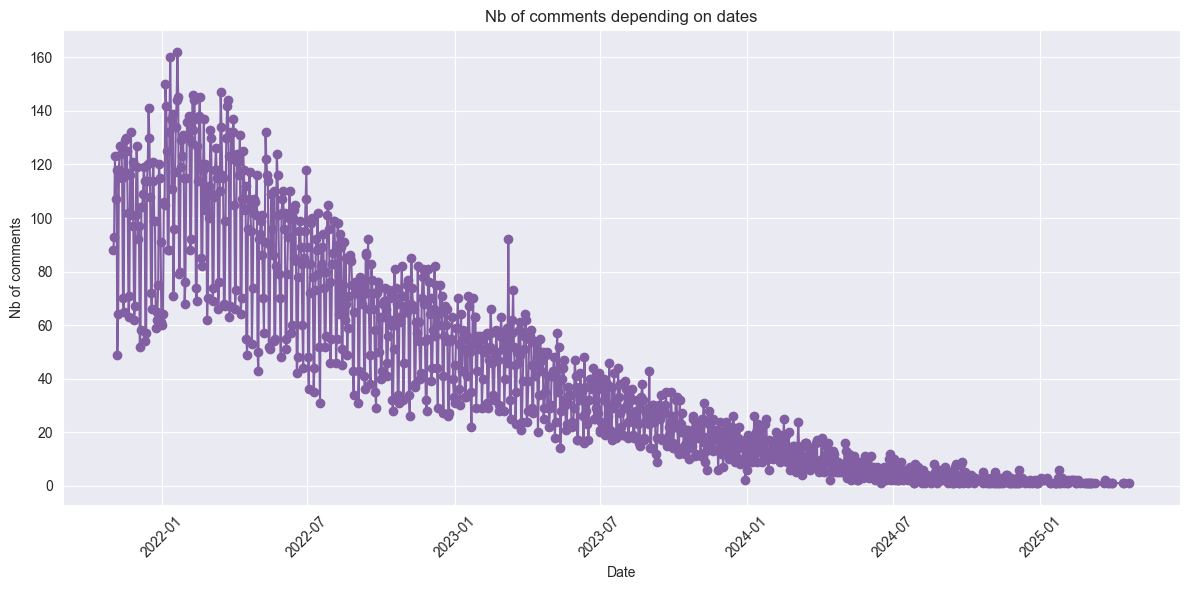

In [16]:
df['CreationDate'] = pd.to_datetime(df['CreationDate'])
df_grouped_by_date = df.groupby(df['CreationDate'].dt.date).size()

# Plot
plt.figure(figsize=(12, 6))
df_grouped_by_date.plot(kind='line', color=default_color, marker='o')
plt.title('Nb of comments depending on dates')
plt.xlabel('Date')
plt.ylabel('Nb of comments')
plt.xticks(rotation=45) 
plt.tight_layout();

## What is the day with min comments ?

In [17]:
# Min comments
min_date = df_grouped_by_date.idxmin()
min_value = df_grouped_by_date.min()

print(f"Date with min nb of comments: {min_date}, Nb of comments: {min_value}")

Date with min nb of comments: 2024-06-16, Nb of comments: 1


## What is the day with max comments ?

In [18]:
# Max comments
max_date = df_grouped_by_date.idxmax()
max_value = df_grouped_by_date.max()

print(f"Date with max nb of comments: {max_date}, Nb of comments: {max_value}")

Date with max nb of comments: 2022-01-20, Nb of comments: 162


## Distribution of num features in all years

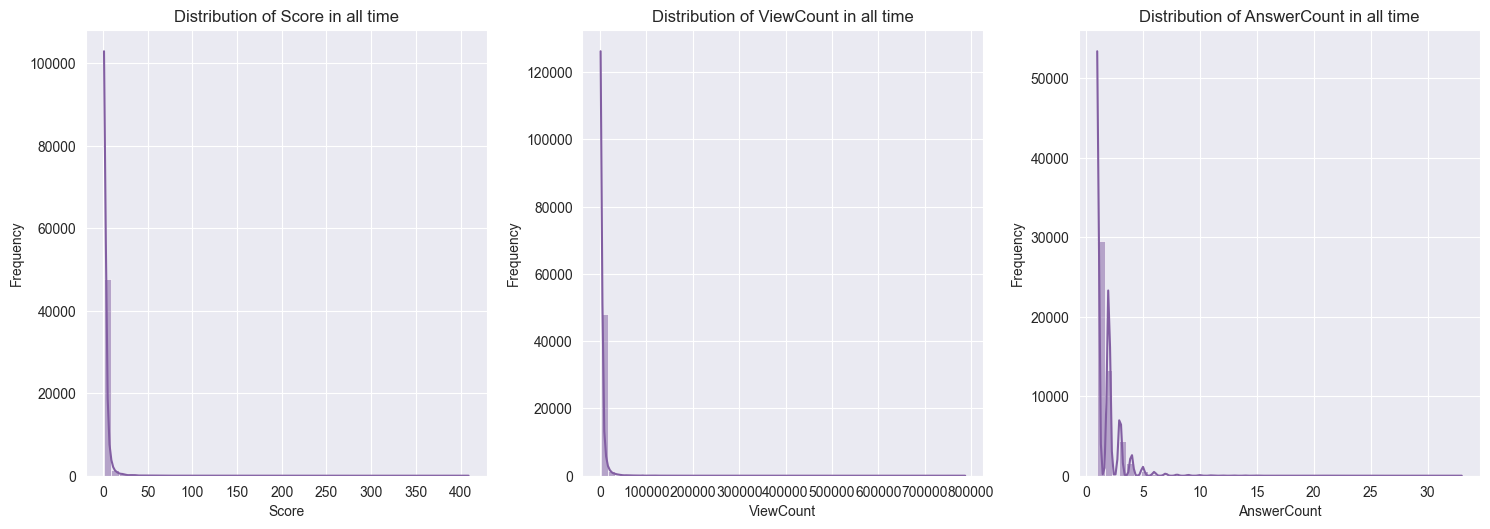

In [19]:
num_cols = df.select_dtypes(include='number').columns.tolist()

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[col], bins=50, kde=True, color=default_color)
    plt.title(f'Distribution of {col} in all time')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    
plt.tight_layout()
plt.show()

## Nb of tags per question

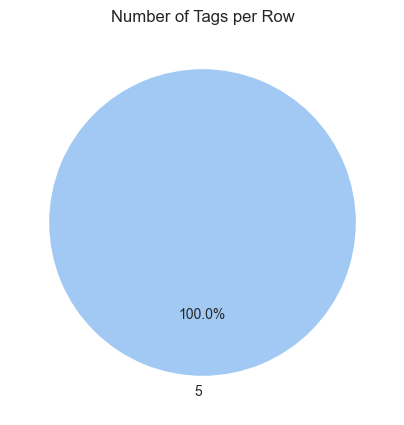

In [20]:
tags_per_row = df['Tags'].apply(len)
tag_counts = tags_per_row.value_counts().sort_index()

plt.figure(figsize=(5, 5))
colors = sns.color_palette('pastel', len(tag_counts))
tag_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Number of Tags per Row')
plt.ylabel('')
plt.show()

## What are the most popular tags across all dates?

In [21]:
# Expload tags
df_exploded = df.explode('Tags')

# Convert CreationDate to year format
df_exploded['Year'] = pd.to_datetime(df_exploded['CreationDate']).dt.year

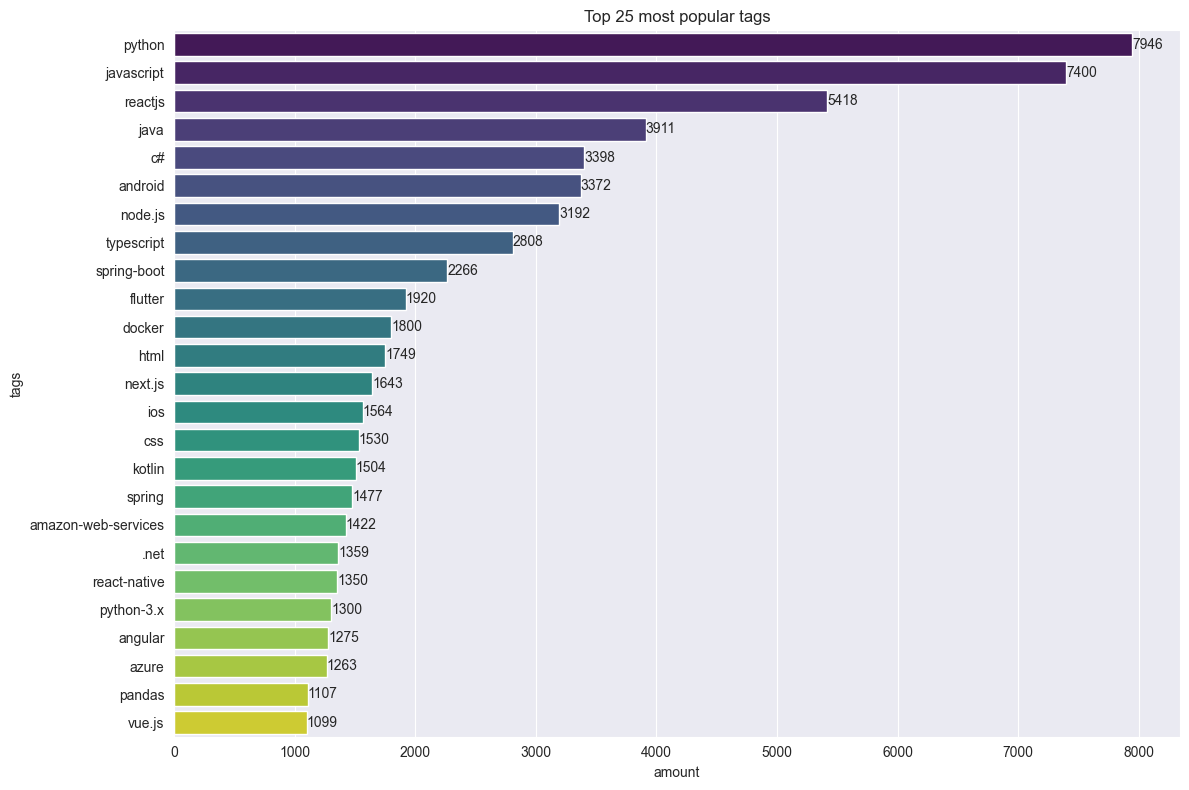

In [22]:
tag_counts = df_exploded['Tags'].value_counts().nlargest(25).reset_index()
tag_counts.columns = ['Tags', 'Count']

plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=tag_counts,
    x='Count',
    y='Tags',
    palette='viridis'
)

for i, value in enumerate(tag_counts['Count']):
    ax.text(
        value + 1,            
        i,                 
        str(value),    
        va='center',
        ha='left',
        fontsize=10
    )

plt.title('Top 25 most popular tags')
plt.xlabel('amount')
plt.ylabel('tags')
plt.tight_layout()
plt.show()

### Per year

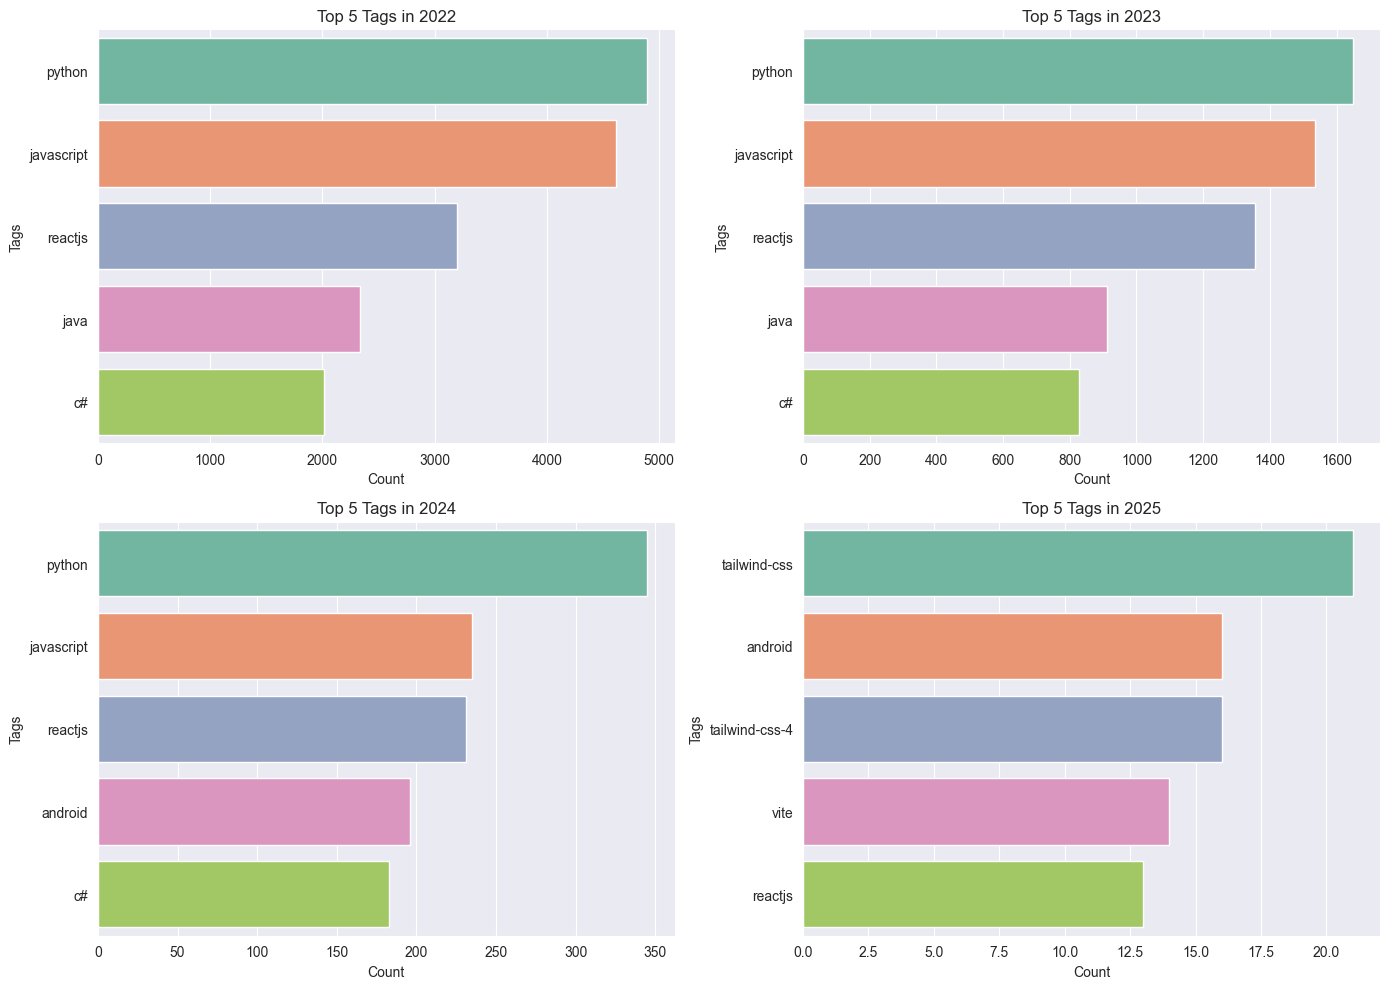

In [23]:
# As in 2021 we have only 2 months -> exlude it in top tag analysis per year
df_filtered = df_exploded[df_exploded['Year'].isin([2022, 2023, 2024, 2025])]
df_grouped_yearly = df_filtered.groupby(['Year', 'Tags']).size().reset_index(name='Count')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, year in enumerate([2022, 2023, 2024, 2025]):
    top_tags = (
        df_grouped_yearly[df_grouped_yearly['Year'] == year]
        .sort_values('Count', ascending=False)
        .head(5)
    )
    
    sns.barplot(
        data=top_tags,
        x='Count',
        y='Tags',
        ax=axes[i],
        palette='Set2'
    )
    axes[i].set_title(f'Top 5 Tags in {year}')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel('Tags')
plt.tight_layout()
plt.show()

## What are the tags that had a higher number of views (all time)?

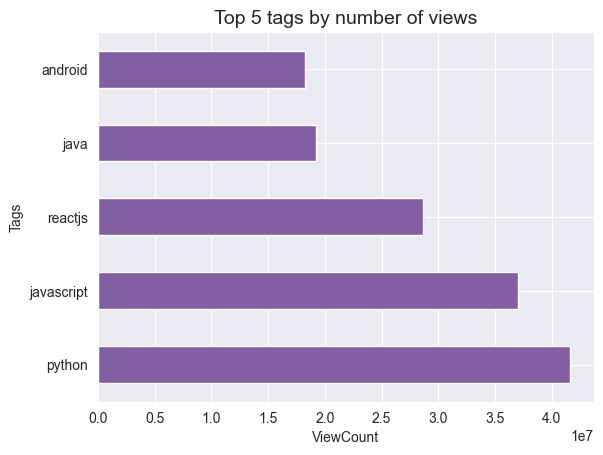

In [24]:
df_grouped_views = df_exploded.groupby('Tags')['ViewCount'].sum().sort_values(ascending=False)
df_grouped_views[0:5].plot(kind='barh', color=default_color)
plt.xlabel('ViewCount')
plt.title('Top 5 tags by number of views', fontsize=14);

## What are the top tags depending on score (all time)?

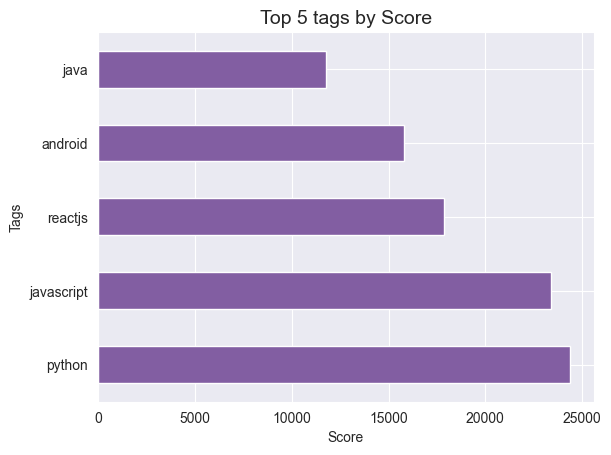

In [25]:
df_grouped_score = df_exploded.groupby('Tags')['Score'].sum().sort_values(ascending=False)
df_grouped_score[0:5].plot(kind='barh', color=default_color)
plt.xlabel('Score')
plt.title('Top 5 tags by Score', fontsize=14);

## What is the count of the most popular tags per year?

In [26]:
compare_top_tags_by_year(df_exploded)


=== COMPARISON OF POPULAR TAGS BY YEAR ===

2022 year (questions: 29,997, tags: 13643):
Top 10 tags:
   1. python               4894 (16.3%)
   2. javascript           4611 (15.4%)
   3. reactjs              3198 (10.7%)
   4. java                 2338 ( 7.8%)
   5. c#                   2018 ( 6.7%)
   6. android              2006 ( 6.7%)
   7. node.js              1906 ( 6.4%)
   8. typescript           1581 ( 5.3%)
   9. spring-boot          1264 ( 4.2%)
  10. flutter              1236 ( 4.1%)

2023 year (questions: 11,703, tags: 8496):
Top 10 tags:
   1. python               1648 (14.1%)
   2. javascript           1535 (13.1%)
   3. reactjs              1356 (11.6%)
   4. java                  912 ( 7.8%)
   5. c#                    829 ( 7.1%)
   6. android               816 ( 7.0%)
   7. typescript            768 ( 6.6%)
   8. node.js               721 ( 6.2%)
   9. next.js               649 ( 5.5%)
  10. spring-boot           629 ( 5.4%)

2024 year (questions: 2,269, tags: 3052)

The tag distribution shows remarkable **consistency from 2022-2024**with Python, JavaScript, and React.js consistently dominating (~10-16% each), indicating stable technology preferences in the developer community. 
However, **2025 data** reveals a dramatic shift toward frontend technologies, with Tailwind CSS becoming the most popular tag (29.6%) and traditional backend languages like Java and C# dropping significantly, though this may reflect the limited sample size (only 71 questions) rather than a genuine trend.

## What is distrubution of all tags?

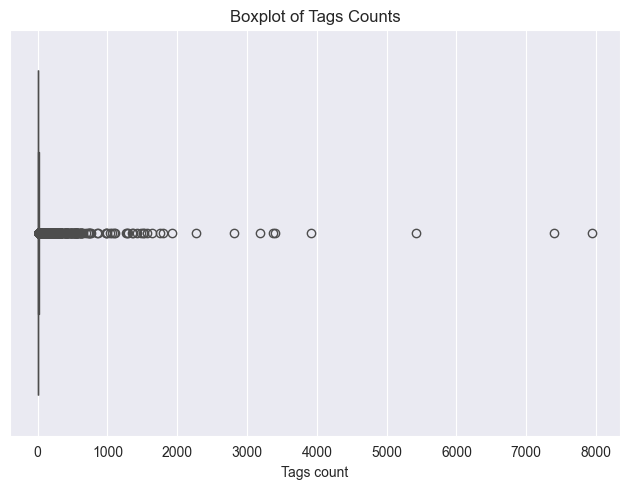

In [27]:
tag_counts = df_exploded['Tags'].value_counts()
sns.boxplot(x=tag_counts.values, color=default_color)
plt.title('Boxplot of Tags Counts')
plt.tight_layout()
plt.xlabel('Tags count');

## Stats on tags per year

In [28]:
years_to_compare = [2022, 2023, 2024, 2025]

for year in years_to_compare:
    year_tags = df_exploded[df_exploded['Year'] == year]['Tags']
    tag_counts = year_tags.value_counts()
    tags_once = tag_counts[tag_counts == 1].index
    print(f"\n==Year {year}==\n")
    print(round(tag_counts.describe().to_frame().T,2))
    
    one_tag_df = df_exploded[(df_exploded['Year'] == year) & (df_exploded['Tags'].isin(tags_once))]
    print(f"\nNumber of unique tags found only once = {one_tag_df['Tags'].nunique()}\n\n")
    


==Year 2022==

         count   mean    std  min  25%  50%  75%     max
count  13643.0  10.99  85.84  1.0  1.0  2.0  5.0  4894.0

Number of unique tags found only once = 5998



==Year 2023==

        count  mean    std  min  25%  50%  75%     max
count  8496.0  6.89  41.09  1.0  1.0  1.0  4.0  1648.0

Number of unique tags found only once = 4280



==Year 2024==

        count  mean   std  min  25%  50%  75%    max
count  3052.0  3.72  13.5  1.0  1.0  1.0  2.0  345.0

Number of unique tags found only once = 1891



==Year 2025==

       count  mean  std  min  25%  50%  75%   max
count  167.0  2.13  3.0  1.0  1.0  1.0  2.0  21.0

Number of unique tags found only once = 121




In [29]:
analyze_tag_trends(df_exploded)


=== TREND TAG ANALYSIS ===
Tags in 2023: 8496
Tags in 2024: 3052
Tags in 2025: 167
Stable tags (in all years): 127

Disappeared in 2024: 6178
Appeared in 2024: 734
Disappeared in 2025: 2918
Appeared in 2025: 33

Dictionary changed in 2024 by: -64.1%
Dictionary changed in 2025 by: -94.5%

Examples of disappeared tags in 2024: ['property-wrapper', 'android-instrumentation', 'http-live-streaming', 'pester', 'xilinx', 'ibm-app-connect', 'trustwallet', 'enter', 'sonarlint-intellij', 'elasticsearch-aggregation']

Examples of disappeared tags in 2025: ['spring-boot-actuator', 'syntax-error', 'environment-variables', 'dialogflow-cx', 'github-desktop', 'glance', 'sqlfluff', 'android-intent', 'text-editor', 'exe']

Examples of new tags in 2025: ['c++-concepts', 'variable-assignment', 'deepseek', 'jetbrains-compose', 'c#-11.0', 'tailwind-variants', 'react-native-screens', 'fastlane-gym', 'razorpay', 'chat']

Examples of stable tags: ['primeng', 'c++', 'java', 'ionic-framework', 'android', 'next-

# 5️⃣ Step 5: Feature engineering
_____________
## Tags

### Semantic tag analysis

In [30]:
from sentence_transformers import SentenceTransformer

unique_tags = df_exploded['Tags'].unique().tolist()
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(unique_tags)

In [31]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(embeddings)

In [32]:
threshold = 0.85  

duplicate_candidates = []
for i in range(len(unique_tags)):
    for j in range(i + 1, len(unique_tags)):
        if similarity_matrix[i, j] > threshold:
            duplicate_candidates.append((unique_tags[i], unique_tags[j], similarity_matrix[i, j]))

In [33]:
duplicates_df = pd.DataFrame(duplicate_candidates, columns=['Tag1', 'Tag2', 'Similarity'])
duplicates_df.sort_values('Similarity', ascending=False).head(10)

,Tag1,Tag2,Similarity
1237,azure-sdk-python,azure-python-sdk,0.996809
767,maven-jaxb2-plugin,jaxb2-maven-plugin,0.996122
730,terraform-provider-helm,terraform-helm-provider,0.995704
1855,ibeacon-android,android-ibeacon,0.991609
1153,google-maps-react,react-google-maps,0.990066
1747,azure-spring-cloud,spring-cloud-azure,0.989822
1577,spring-test-mvc,spring-mvc-test,0.985522
759,nginx-ingress,ingress-nginx,0.984949
1072,ef-core-3.1,ef-core-3.0,0.984879
1214,azure-java-sdk,azure-sdk-for-java,0.983046


In [34]:
duplicates_df.shape

(1862, 3)

### Unifying symilar tags

In [35]:
import networkx as nx

G = nx.Graph()
threshold = 0.85

for tag1, tag2, sim in duplicates_df.values:
    if sim >= threshold:
        G.add_edge(tag1, tag2)

clusters = list(nx.connected_components(G))

tag_map = {}
for cluster in clusters:
    main_tag = sorted(cluster, key=lambda x: (len(x), x))[0]
    for tag in cluster:
        tag_map[tag] = main_tag

def unify_tags(tag_list, mapping):
    return [mapping.get(tag, tag) for tag in tag_list]

df_cleaned = df.copy()
df_cleaned['Tags'] = df_cleaned['Tags'].apply(lambda tags: unify_tags(tags, tag_map))

In [36]:
unique_tags_after = df_cleaned['Tags'].explode()

print(f'Nb of unique tags before:{ len(unique_tags)}')
print(f'Nb of unique tags after: {unique_tags_after.nunique()}')

Nb of unique tags before:16980
Nb of unique tags after: 15511


In [37]:
df_cleaned.shape

(50000, 7)

### Removing rare tags 

In [38]:
df_cleaned_exploded = df_cleaned.explode('Tags')
tag_counts_cleaned = df_cleaned_exploded['Tags'].value_counts()

In [39]:
upper_bound_tags = describe_iqr_threshold(tag_counts_cleaned, 'Tags')

Tags - Q1 (25%): 1.00
Tags - Q3 (75%): 6.00
Tags - IQR (Q3 - Q1): 5.00
Tags - Recommended upper threshold (Q3 + 1.5 * IQR): 14


In [40]:
valid_tags = tag_counts_cleaned[tag_counts_cleaned > upper_bound_tags].index
valid_tags.nunique()

2128

In [41]:
df_filtered = df_cleaned.copy()
df_filtered['Tags'] = df_filtered['Tags'].apply(lambda tags: [tag for tag in tags if tag in valid_tags])

df_filtered = df_filtered[df_filtered['Tags'].map(len) > 0]

print(f'Size after filtering: {df_filtered.shape}')
print(f"Nb of unique tags: {df_filtered['Tags'].explode().nunique()}")

Size after filtering: (49942, 7)
Nb of unique tags: 2128


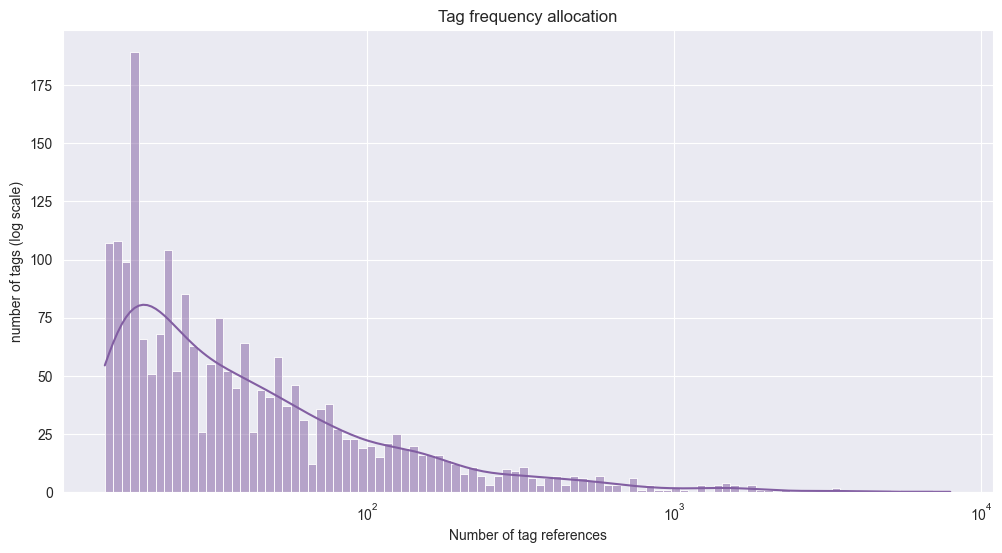

In [42]:

all_tags = df_filtered['Tags'].explode()
tag_counts = all_tags.value_counts()

plt.figure(figsize=(12, 6))
sns.histplot(tag_counts, bins=100, log_scale=(True), color=default_color, kde=True)

plt.xlabel('Number of tag references')
plt.ylabel('number of tags (log scale)')
plt.title('Tag frequency allocation')
plt.show()

The frequency distribution of tags has a characteristic long-tailed behavior. This is typical for text tasks. We kept the most popular tags and cuted off the low-frequency ones to avoid overtraining and unbalanced learning of the model on single examples.

In [43]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49942 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Title         49942 non-null  object        
 1   Body          49942 non-null  object        
 2   Tags          49942 non-null  object        
 3   Score         49942 non-null  int64         
 4   ViewCount     49942 non-null  int64         
 5   AnswerCount   49942 non-null  int64         
 6   CreationDate  49942 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 3.0+ MB


## Text

### Combine the title and the body

In [44]:
df_filtered['text_raw'] = df_filtered['Title'] + ' ' + df['Body']

In [45]:
df_filtered.head()

,Title,Body,Tags,Score,ViewCount,AnswerCount,CreationDate,text_raw
0,"""git submodule update"" failed with 'fatal: det...",<p>I mounted a new hard disk drive in my Linux...,"[linux, git, ubuntu, filesystems]",409,787579,33,2022-07-14 09:44:16,"""git submodule update"" failed with 'fatal: det..."
1,"Error ""'DataFrame' object has no attribute 'ap...",<p>I am trying to append a dictionary to a Dat...,"[python, pandas, dataframe, concatenation, val...",320,720993,4,2023-04-07 07:05:59,"Error ""'DataFrame' object has no attribute 'ap..."
2,"How can I fix the ""zsh: command not found: pyt...","<p>Since I got the <a href=""https://en.wikiped...","[python, macos, terminal, macos-monterey]",267,678460,21,2022-03-23 18:02:02,"How can I fix the ""zsh: command not found: pyt..."
3,Compilation error after upgrading to JDK 21 - ...,"<p>After upgrading to JDK 21, I have the follo...","[spring-boot, compiler-errors, upgrade, lombok...",380,443211,15,2023-09-25 09:05:11,Compilation error after upgrading to JDK 21 - ...
4,"OpenAI API error 429: ""You exceeded your curre...",<p>I'm making a Python script to use OpenAI vi...,"[python, openai-api, chatgpt-api]",177,437883,5,2023-03-31 11:58:04,"OpenAI API error 429: ""You exceeded your curre..."


### Cleaning raw text

In [46]:
# Apply cleaning function
df_filtered['text_clean'] = df_filtered['text_raw'].apply(clean_text)

In [47]:
pd.set_option('display.max_colwidth', 100)
df_filtered[['text_raw', 'text_clean']].head(2)

,text_raw,text_clean
0,"""git submodule update"" failed with 'fatal: detected dubious ownership in repository at...' <p>I ...",git submodule update fail fatal detect dubious ownership repository mount new hard disk drive li...
1,"Error ""'DataFrame' object has no attribute 'append'"" <p>I am trying to append a dictionary to a ...",error dataframe object attribute append try append dictionary dataframe object get following err...


### Find & delete more frequented technical words

In [48]:
vect = CountVectorizer()
X = vect.fit_transform(df_filtered['text_clean'])

words = vect.get_feature_names_out()
counts = np.asarray(X.sum(axis=0)).flatten()

word_counts = pd.DataFrame({'word': words, 'count': counts})
top_words = word_counts.sort_values(by='count', ascending=False)

print(top_words.head(60))

               word  count
231581          use  90594
66963         error  69149
74181          file  64374
83324           get  57979
112179         java  56874
141921         name  55120
102731       import  54486
10458           app  50545
48500          data  48067
225438          try  47753
232552         user  47705
100148           id  44119
187498          run  43737
155521          org  43538
33412         class  42370
184406       return  42279
35485          code  39793
39922         const  37849
226555         type  37818
217431         test  37539
236433      version  37304
243885         work  37125
235176        value  35919
211029       string  34883
144086          new  34301
25104         build  34111
136546       module  32364
225299         true  31394
176569        react  30342
80904      function  29400
146358         node  28989
43142        create  28478
8705        android  26640
125536          log  26620
2952            add  26059
172612       python  25753
7

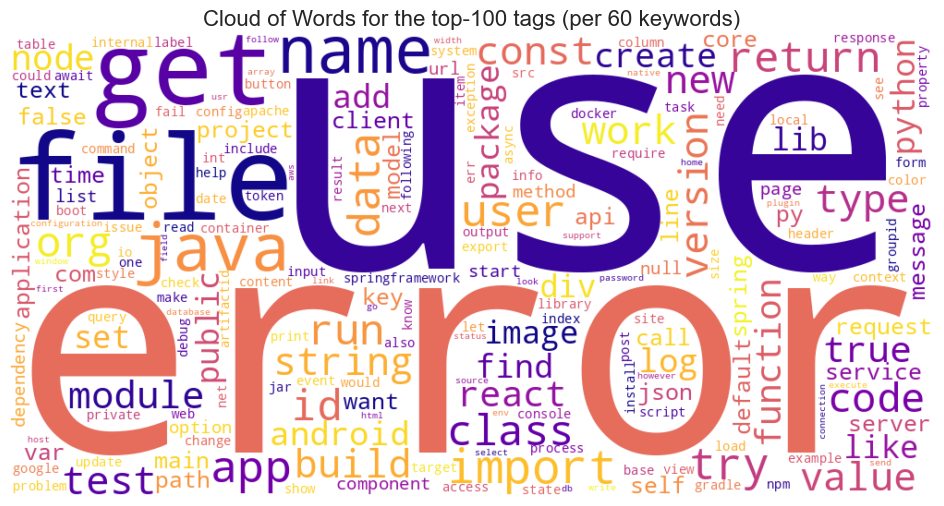

In [49]:
top_tags = df_filtered['Tags'].explode().value_counts().head(300).index

mask = df_filtered['Tags'].apply(lambda tag_list: any(tag in top_tags for tag in tag_list))
tag_texts = df_filtered[mask]['text_clean']
text_combined = ' '.join(tag_texts)

vect_limited = CountVectorizer(vocabulary=top_words['word']
                               .head(300).tolist())
X_tag = vect_limited.fit_transform([text_combined])
freqs = dict(zip(vect_limited.get_feature_names_out(), X_tag.toarray()[0]))

wordcloud = WordCloud(width=1000, height=500, background_color='white', colormap='plasma').generate_from_frequencies(freqs)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Cloud of Words for the top-100 tags (per 60 keywords)', fontsize=16)
plt.show()

In [50]:
custom_stopwords = {
    'error', 'file', 'import', 'get', 'try', 'code', 'return', 'see', 
    'get', 'use', 'im', 'new', 'version', 'name', 'com', 'false', 'would', 'start', 'need',
    'run', 'work', 'like', 'type', 'true', 'id', 'create', 'build', 'find', 'true',
    'message', 'need', 'issue', 'fail', 'also', 'message', 'add', 'text', 'want', 'line', 'text', 'project'
}

# Call function
df_filtered['text_clean'] = df_filtered['text_clean'].apply(
    lambda x: remove_custom_stopwords(x, custom_stopwords)
)

### Text length by question

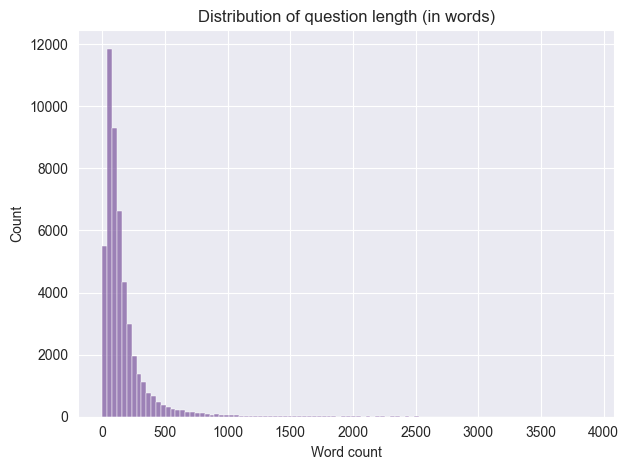

In [51]:
words_count = df_filtered['text_clean'].str.split().apply(len)

sns.histplot(words_count,color=default_color, bins=100)
plt.title('Distribution of question length (in words)')
plt.xlabel('Word count')
plt.tight_layout();

### Cleaning: Rare Words in the Entire Dataset
To identify words that appear too infrequently to carry meaningful information, we use the Interquartile Range (IQR) method to define a lower frequency threshold.

In [52]:
top_words[top_words['count'] == 1].value_counts().sum()

101888

The analysis reveals that more than 100,000 words occur only once, indicating a high number of rare or potentially noisy terms in the dataset.

In [53]:
upper_bound_words = describe_iqr_threshold(top_words['count'], name='Word frequency')

Word frequency - Q1 (25%): 1.00
Word frequency - Q3 (75%): 4.00
Word frequency - IQR (Q3 - Q1): 3.00
Word frequency - Recommended upper threshold (Q3 + 1.5 * IQR): 8


In [54]:
valid_words = top_words[top_words['count'] > upper_bound_words]['word']
valid_words_set = set(valid_words.tolist())

# Calculating nb words
len(valid_words_set)

36285

In [55]:
# Copy df
df_final = df_filtered[['text_clean', 'Tags' ]].copy()

# Cleaning rare words
df_final['text_clean'] = df_final['text_clean'].apply(
    lambda text: ' '.join([word for word in text.split() if word in valid_words_set])
)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49942 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text_clean  49942 non-null  object
 1   Tags        49942 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [56]:
df_final.head()

,text_clean,Tags
0,git submodule update fatal detect ownership repository mount hard disk drive linux workstation l...,"[linux, git, ubuntu, filesystems]"
1,dataframe object attribute append append dictionary dataframe object following attributeerror da...,"[python, pandas, dataframe, concatenation, valueerror]"
2,fix zsh command python macos monterey python atom ide atom python since macos monterey update su...,"[python, macos, terminal, macos-monterey]"
3,compilation upgrade jdk member field jctree upgrade jdk following compilation spring boot fatal ...,"[spring-boot, compiler-errors, upgrade, lombok, java-14]"
4,openai api exceed current quota please check plan billing detail make python script openai via a...,"[python, openai-api, chatgpt-api]"


### Cleaning: Number of Words in Sentence

Sentences with fewer than 5 words are assumed to carry limited semantic information. Hence, these rows will be excluded from further analysis.

In [57]:
# Calculating nb of words in the final df
words_count_final = df_final['text_clean'].str.split().apply(len)

words_count_final.describe()

count    49942.000000
mean       159.596132
std        209.080528
min          2.000000
25%         59.000000
50%        101.000000
75%        177.000000
max       3367.000000
Name: text_clean, dtype: float64

In [58]:
min_words = 5
short_questions_count = (words_count_final < min_words).sum()
print(f'Number of lines where less than 5 words: {short_questions_count}')

short_questions = df_final[words_count_final < min_words]
short_questions[['text_clean', 'Tags']].head(10)

Number of lines where less than 5 words: 6


,text_clean,Tags
1975,problem vue,"[typescript, firebase, vue.js, vuejs2, vue-composition-api]"
6448,target element inside,"[javascript, vue.js, vuejs2, vue-composition-api, vue-script-setup]"
14904,sweetalert vue,"[laravel, vuejs2, sweetalert, inertiajs, vue-script-setup]"
24689,vue boolean data parent,"[javascript, vue.js, vuejs2, vue-composition-api, vue-script-setup]"
28953,pinia composition api,"[vue.js, vuex, vue-composition-api, pinia]"
39717,solve sveltekit svelte,"[css, sas, svelte, svelte, svelte]"


In [59]:
q_high = round(words_count_final.quantile(0.99))

long_questions_count = (words_count_final > q_high).sum()
print(f'Number of lines where more than {q_high} words: {long_questions_count}')

long_questions_count = df_final[words_count_final > q_high]
long_questions_count[['text_clean', 'Tags']].head(10)

Number of lines where more than 1122 words: 500


,text_clean,Tags
21,importerror soft unicode markupsafe docker container airflow postgres nevertheless many show dow...,"[python, docker, docker-compose, dependencies, importerror]"
37,could resolve configuration app debugruntimeclasspath dependency android studio chipmunk gradel ...,"[android, gradle-plugin, build.gradle]"
67,android studio compiledebugjavawithjavac task current target kaptgeneratestubsdebugkotlin task c...,"[android, android-studio, kotlin, gradle, gradle-plugin]"
207,pyspark spark sparkexception job abort due stage failure task stage time java net socketexceptio...,"[python, apache-spark, pyspark, apache-spark-sql]"
275,app kaptgeneratestubsdebugkotlin unknown kotlin jvm target change android studio ladybug please ...,"[android, kotlin, android-studio, jvm, build.gradle]"
286,java lang noclassdeffounderror jakarta servlet kubernetes exactly kubectl apply auth yaml statem...,"[java, spring-boot, docker, kubernetes, spring-security]"
469,public key authentication jsch openssh key establish ssh connection kotlin jsch jcraft jsch jsch...,"[java, kotlin, ssh, private-key]"
503,instal node sas install node sas react give lot thing none delete install still update everythin...,"[node.js, reactjs, npm, sas, node-sass]"
562,bypass cloudflare python unable scrape website status even though every available solution inter...,"[python, web-scraping, beautifulsoup, cloudflare]"
600,multiple definition first define gcc gcc bit look around stackoverflow wider internet identify c...,"[c, linux, gcc]"


In [60]:
# Delete those rows
df_final = df_final[(words_count > min_words) & (words_count < q_high)].reset_index(drop=True)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49298 entries, 0 to 49297
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text_clean  49298 non-null  object
 1   Tags        49298 non-null  object
dtypes: object(2)
memory usage: 770.4+ KB


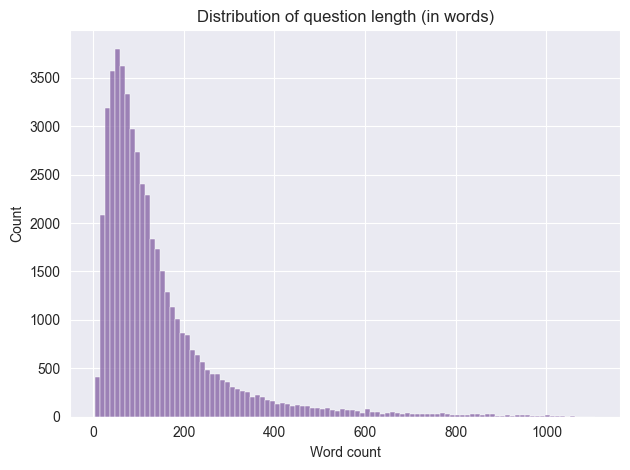

In [61]:
words_count_final = df_final['text_clean'].str.split().apply(len)
sns.histplot(words_count_final,color=default_color, bins=100)
plt.title('Distribution of question length (in words)')
plt.xlabel('Word count')
plt.tight_layout();

## Final check on tags

In [62]:
# Assure that there is no duplicate tags inside each line
df_final['Tags'] = df_final['Tags'].apply(lambda tags: list(set(tags)))
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49298 entries, 0 to 49297
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text_clean  49298 non-null  object
 1   Tags        49298 non-null  object
dtypes: object(2)
memory usage: 770.4+ KB


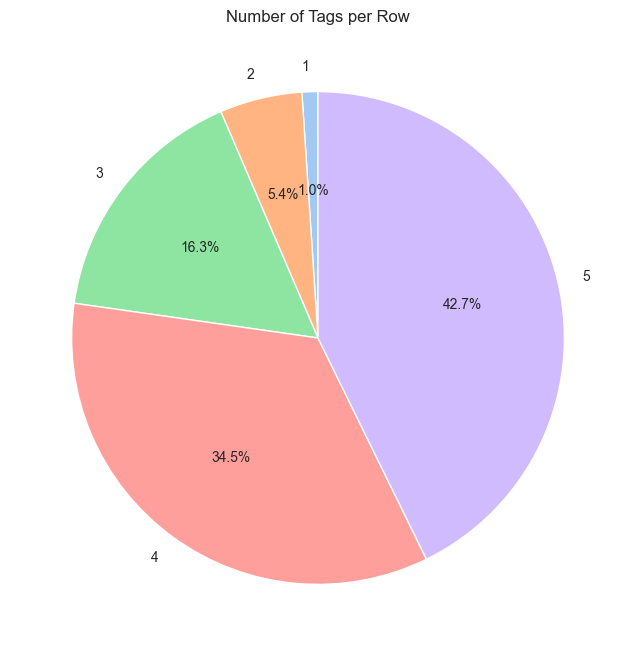

In [63]:
tags_per_row = df_final['Tags'].apply(len)
tag_counts = tags_per_row.value_counts().sort_index()

plt.figure(figsize=(8, 8))
colors = sns.color_palette('pastel', len(tag_counts))
tag_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Number of Tags per Row')
plt.ylabel('')
plt.show()

# Save data

In [64]:
df_final.to_csv('../data/data_clean_stackoverflow.csv', index=False)

In [65]:
df_final.sample(2)

,text_clean,Tags
31971,zen core flop per cycle bit precision fp since amd zen bit wide operation vector data following ...,"[performance, cpu-architecture, avx, x86]"
7344,table uuid column postgres db sqlalchemy table sqlalchemy declarativebase model table class base...,"[uuid, sqlalchemy, python-dataclasses, python, postgrest]"


In [66]:
df_final['text_clean'].to_csv('../data/X_text.csv', index=False)
df_final['text_clean'].head(2)

0    git submodule update fatal detect ownership repository mount hard disk drive linux workstation l...
1    dataframe object attribute append append dictionary dataframe object following attributeerror da...
Name: text_clean, dtype: object

In [67]:
df_final['Tags'].to_csv('../data/Y_tags .csv', index=False)
df_final['Tags'].head(2)

0                         [ubuntu, linux, filesystems, git]
1    [dataframe, valueerror, python, concatenation, pandas]
Name: Tags, dtype: object